In [1]:
import networkx as nx
import osmnx as ox

In [2]:
# original_waypoints = [{'lat': 51.58448, 'lng': -0.278585}, {'lat': 51.506466, 'lng': -0.141813}, {'lat': 51.507271, 'lng': -0.141906}, {'lat': 51.51314499999999, 'lng': -0.124336}, {'lat': 51.51177759999999, 'lng': -0.124189}]
# alt1_waypoints = [{'lat': 51.58448, 'lng': -0.278585}, {'lat': 51.523346, 'lng': -0.157027}, {'lat': 51.52328499999999, 'lng': -0.157005}, {'lat': 51.507504, 'lng': -0.128672}, {'lat': 51.5073886, 'lng': -0.128322}]
# alt2_waypoints = [{'lat': 51.51177759999999, 'lng': -0.124189}]
# original_travel_modes = [('Walking', 'Walk to Kingsbury'), ('Transit', 'Subway'), ('Walking', 'Walk to Green Park'), ('Transit', 'Subway'), ('Walking', 'Walk to Covent Garden, London, UK')]
# alt1_travel_modes = [('Walking', 'Walk to Kingsbury'), ('Transit', 'Subway'), ('Walking', 'Walk to Baker Street'), ('Transit', 'Subway'), ('Walking', 'Walk to Charing Cross, London WC2N 5DP, UK')]
# alt2_travel_modes = [('Walking', 'Walk to Covent Garden, London, UK')]

original_waypoints = [{'lat': 51.50581, 'lng': -0.226336}, {'lat': 51.524052, 'lng': -0.143919}, {'lat': 51.52290920000001, 'lng': -0.1440287}, {'lat': 51.534679, 'lng': -0.146679}, {'lat': 51.53584559999999, 'lng': -0.1554668}]
alt1_waypoints = [{'lat': 51.50581, 'lng': -0.226336}, {'lat': 51.522274, 'lng': -0.156813}, {'lat': 51.5226814, 'lng': -0.1576824}]
alt2_waypoints = [{'lat': 51.52463419999999, 'lng': -0.1586033}, {'lat': 51.5245524, 'lng': -0.1580993}, {'lat': 51.5249867, 'lng': -0.1579032}, {'lat': 51.5290939, 'lng': -0.1618951}, {'lat': 51.52951849999999, 'lng': -0.1608263}, {'lat': 51.5349083, 'lng': -0.158779}, {'lat': 51.5350216, 'lng': -0.1587985}, {'lat': 51.53584559999999, 'lng': -0.1554668}]
original_travel_modes = [('Walking', "Walk to Shepherd's Bush Market"), ('Transit', 'Subway'), ('Walking', 'Walk to Great Portland Street (Stop F)'), ('Transit', 'Bus'), ('Walking', 'Walk to Outer Cir, London NW1 4RY, UK')]
alt1_travel_modes = [('Walking', "Walk to Shepherd's Bush Market"), ('Transit', 'Subway'), ('Walking', 'Walk to Baker Street, Marylebone Rd, London NW1 5LJ, UK')]
alt2_travel_modes = [('Walking', 'Head <b>north</b> on <b>Baker St</b>/<wbr/><b>A41</b> toward <b>Melcombe St</b><div style="font-size:0.9em">Continue to follow Baker St</div>'), ('Walking', 'Sharp <b>right</b> onto <b>Outer Cir</b>'), ('Walking', 'Turn <b>left</b>'), ('Walking', 'Turn <b>left</b>'), ('Walking', 'Turn <b>right</b>'), ('Walking', 'Turn <b>left</b>'), ('Walking', 'Turn <b>left</b> toward <b>Outer Cir</b>'), ('Walking', 'Turn <b>right</b> onto <b>Outer Cir</b><div style="font-size:0.9em">Destination will be on the left</div>')]

origin = original_waypoints[0]['lng'], original_waypoints[0]['lat']
end = original_waypoints[-1]['lng'], original_waypoints[-1]['lat']

north, south, east, west = -100, 100, -100, 100
for waypoint in original_waypoints + alt1_waypoints + alt2_waypoints:
    if waypoint['lat'] > north:
        north = waypoint['lat']
    if waypoint['lat'] < south:
        south = waypoint['lat']
    if waypoint['lng'] > east:
        east = waypoint['lng']
    if waypoint['lng'] < west:
        west = waypoint['lng']

print(north, south, east, west)

G = ox.graph_from_bbox(north, south, east, west, network_type="walk")

51.53584559999999 51.50581 -0.143919 -0.226336


/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


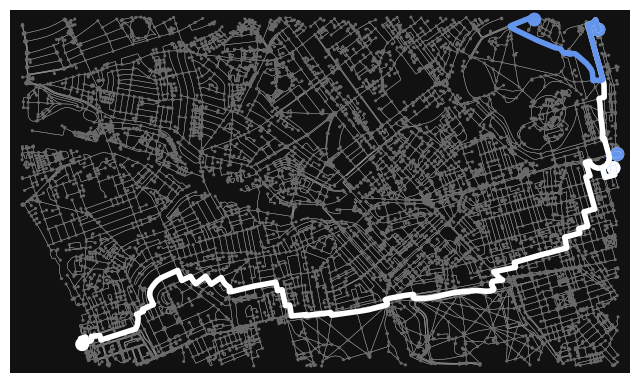

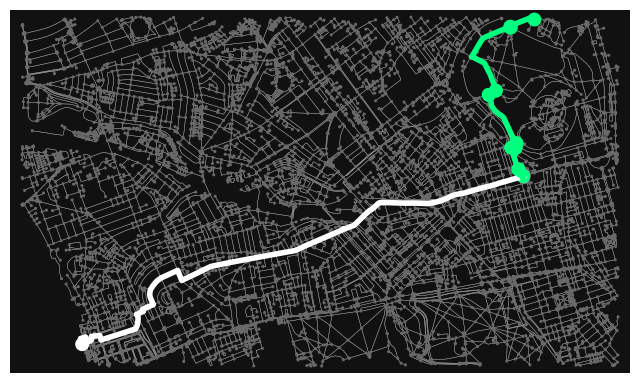

In [3]:
# plot routes

paths = []
route_colors = []
for i in range(1, len(original_waypoints)):
    origin = original_waypoints[i-1]['lng'], original_waypoints[i-1]['lat']
    end = original_waypoints[i]['lng'], original_waypoints[i]['lat']# find the nearest node to the start location
    orig_node = ox.nearest_nodes(G, origin[0], origin[1])
    end_node = ox.nearest_nodes(G, end[0], end[1])
    paths.append(nx.shortest_path(G, orig_node, end_node))
    if original_travel_modes[i][0] == "Walking":
        route_colors.append("cornflowerblue")
    else:
        route_colors.append("white")

fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=0.6, route_colors=route_colors, route_alpha=1, node_color='dimgrey', edge_linewidth=0.3, node_size=5, dpi=300)
fig.savefig("output/original_zoo.png", dpi=300)
fig.clf()

paths = []
route_colors = []
alt_waypoints = alt1_waypoints + alt2_waypoints
alt_travel_modes = alt1_travel_modes + alt2_travel_modes
for i in range(1, len(alt_waypoints)):
    origin = alt_waypoints[i-1]['lng'], alt_waypoints[i-1]['lat']
    end = alt_waypoints[i]['lng'], alt_waypoints[i]['lat']# find the nearest node to the start location
    orig_node = ox.nearest_nodes(G, origin[0], origin[1])
    end_node = ox.nearest_nodes(G, end[0], end[1])
    paths.append(nx.shortest_path(G, orig_node, end_node))
    # route_colors.append("g")
    if alt_travel_modes[i][0] == "Walking":
        route_colors.append("springgreen")
    else:
        route_colors.append("white")

fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=0.3, route_colors=route_colors, route_alpha=1, node_color='dimgrey', edge_linewidth=0.3, node_size=5, dpi=300)
fig.savefig("output/alt_zoo.png", dpi=300)